In [1]:
import os, sys
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
from analysis.FultonMarketAnalysis import FultonMarketAnalysis
from pymbar import MBAR, timeseries

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



In [2]:
def free_energy_end(self):
    #sliced state specific reduced potentials
    sliced_state_specific = np.empty(self.energies.shape[0:2])
    for i in range(sliced_state_specific.shape[-1]):
        sliced_state_specific[:, i] = self.energies[:, i, i]

    #average state specific reduced potentials
    average_reduced_potentials = np.mean(sliced_state_specific, axis=-1)
    #detect equil based on average reduced potential
    t0, g, Neff_max = timeseries.detect_equilibration(average_reduced_potentials)
    print('t0', t0)
    #Average reduced potentials post equil
    post_equil_average = average_reduced_potentials[t0:]
    #Full set post equil
    post_equil = self.energies[t0:]
    #Obtain indices of these that are uncorrelated
    indices = np.array(timeseries.subsample_correlated_data(post_equil_average, g=g))

    #obtain the samples that are uncorrelated based on these indices
    uncorrelated_samples = post_equil[indices]
    #Do MBAR
    N_k = [uncorrelated_samples.shape[0] for i in range(uncorrelated_samples.shape[1])]
    mbar = MBAR(uncorrelated_samples.T, N_k, initialize='BAR')
    
    return t0, mbar.compute_free_energy_differences()

In [3]:
def free_energy_convergence(self, size_domain=50, start=1000):
    
    slice_vals = np.arange(start, self.energies.shape[0]+size_domain, size_domain, dtype=np.int32)
    
    xs = []
    ys = []
    ys_stds = []

    print(slice_vals)
    for slice_val in slice_vals:
        try:     
            print(slice_val)
            sliced = self.energies[:slice_val]
            #sliced state specific reduced potentials
            sliced_state_specific = np.empty(sliced.shape[0:2])
            for i in range(sliced_state_specific.shape[-1]):
                sliced_state_specific[:, i] = sliced[:, i, i]
    
            
            #average state specific reduced potentials
            average_reduced_potentials = np.mean(sliced_state_specific, axis=-1)
            #detect equil based on average reduced potential
            t0, g, Neff_max = timeseries.detect_equilibration(average_reduced_potentials)
            #Average reduced potentials post equil
            post_equil_average = average_reduced_potentials[t0:]
            #Full set post equil
            post_equil = sliced[t0:]
            #Obtain indices of these that are uncorrelated
            indices = np.array(timeseries.subsample_correlated_data(post_equil_average, g=g))
    
            #obtain the samples that are uncorrelated based on these indices
            uncorrelated_samples = post_equil[indices]
            #Do MBAR
            N_k = [uncorrelated_samples.shape[0] for i in range(uncorrelated_samples.shape[1])]
            mbar = MBAR(uncorrelated_samples.T, N_k, initialize='BAR')
            
            #Obtain dG
            dGs = mbar.compute_free_energy_differences()
    
            xs.append(slice_val)
            ys.append(dGs['Delta_f'][0, -1])
            ys_stds.append(dGs['dDelta_f'][0, -1])
        except:
            pass
    
    return np.array(xs), np.array(ys), np.array(ys_stds)

In [4]:
pairs = (['/expanse/lustre/projects/iit122/dcooper/JustDoIt/umbrella_sampling/test_equilibration/centroid_1_6/', '/expanse/lustre/projects/iit122/dcooper/JustDoIt/centroids/centroid_1.pdb'],
         ['/expanse/lustre/projects/iit122/dcooper/JustDoIt/umbrella_sampling/test_equilibration/centroid_6_8/', '/expanse/lustre/projects/iit122/dcooper/JustDoIt/centroids/centroid_6.pdb'],
         ['/expanse/lustre/projects/iit122/dcooper/JustDoIt/umbrella_sampling/test_equilibration/centroid_8_1//', '/expanse/lustre/projects/iit122/dcooper/JustDoIt/centroids/centroid_8.pdb'],
        ['/expanse/lustre/projects/iit122/josephdb/JustDoIt/centroids/centroid_1_PTwR/centroid_1_1/', '/expanse/lustre/projects/iit122/dcooper/JustDoIt/centroids/centroid_1.pdb'],
        ['/expanse/lustre/projects/iit122/josephdb/JustDoIt/centroids/centroid_6_PTwR/centroid_6_1/', '/expanse/lustre/projects/iit122/dcooper/JustDoIt/centroids/centroid_6.pdb'],
        ['/expanse/lustre/projects/iit122/josephdb/JustDoIt/centroids/centroid_8_PTwR/centroid_8_1/', '/expanse/lustre/projects/iit122/dcooper/JustDoIt/centroids/centroid_8.pdb'],)

analyzers = []
for direc, pdbfn in pairs:
    a_class = FultonMarketAnalysis(direc, pdbfn, skip=10)
    #setattr(a_class, "free_energy_convergence", free_energy_convergence)
    a_class.equilibration_method = 'energy'
    analyzers.append(a_class)

11/01/2024 13:45:09 // Found storage directory at /expanse/lustre/projects/iit122/dcooper/JustDoIt/umbrella_sampling/test_equilibration/centroid_1_6/saved_variables
11/01/2024 13:45:10 // Shapes of temperature arrays: [(0, (29,)), (1, (29,)), (2, (29,)), (3, (29,)), (4, (29,))]
11/01/2024 13:45:19 // Detected interpolations at: [[], [], [], [], []]
11/01/2024 13:45:19 // Shape of final energies determined to be: (8605, 29, 29)
11/01/2024 13:45:19 // Found storage directory at /expanse/lustre/projects/iit122/dcooper/JustDoIt/umbrella_sampling/test_equilibration/centroid_6_8/saved_variables
11/01/2024 13:45:20 // Shapes of temperature arrays: [(0, (26,)), (1, (26,)), (2, (26,)), (3, (26,)), (4, (26,))]
11/01/2024 13:45:27 // Detected interpolations at: [[], [], [], [], []]
11/01/2024 13:45:27 // Shape of final energies determined to be: (9600, 26, 26)
11/01/2024 13:45:27 // Found storage directory at /expanse/lustre/projects/iit122/dcooper/JustDoIt/umbrella_sampling/test_equilibration/ce


******* JAX 64-bit mode is now on! *******
*     JAX is now set to 64-bit mode!     *
*   This MAY cause problems with other   *
*      uses of JAX in the same code.     *
******************************************

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


11/01/2024 13:45:39 // Shape of final energies determined to be: (8211, 32, 32)
11/01/2024 13:45:39 // Found storage directory at /expanse/lustre/projects/iit122/josephdb/JustDoIt/centroids/centroid_1_PTwR/centroid_1_1/saved_variables
11/01/2024 13:45:41 // Shapes of temperature arrays: [(0, (101,)), (1, (101,)), (2, (101,))]
11/01/2024 13:45:45 // Detected interpolations at: [[], [], []]
11/01/2024 13:45:46 // Shape of final energies determined to be: (1476, 101, 101)
11/01/2024 13:45:46 // Found storage directory at /expanse/lustre/projects/iit122/josephdb/JustDoIt/centroids/centroid_6_PTwR/centroid_6_1/saved_variables
11/01/2024 13:45:47 // Shapes of temperature arrays: [(0, (106,)), (1, (106,)), (2, (106,))]
11/01/2024 13:45:51 // Detected interpolations at: [[], [], []]
11/01/2024 13:45:51 // Shape of final energies determined to be: (1404, 106, 106)
11/01/2024 13:45:51 // Found storage directory at /expanse/lustre/projects/iit122/josephdb/JustDoIt/centroids/centroid_8_PTwR/centro

t0 5648
5648 <analysis.FultonMarketAnalysis.FultonMarketAnalysis object at 0x15555045fa70>


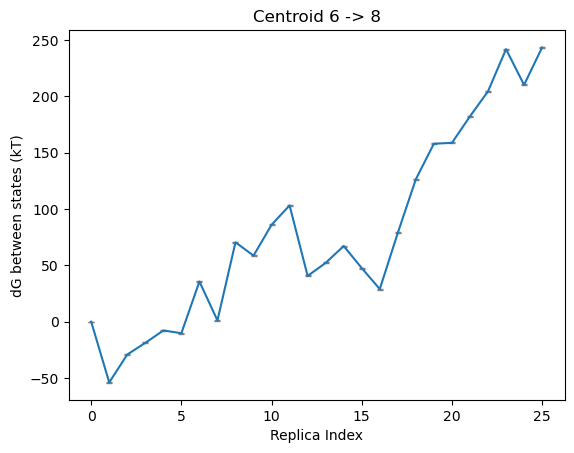

t0 447
447 <analysis.FultonMarketAnalysis.FultonMarketAnalysis object at 0x1555126691c0>


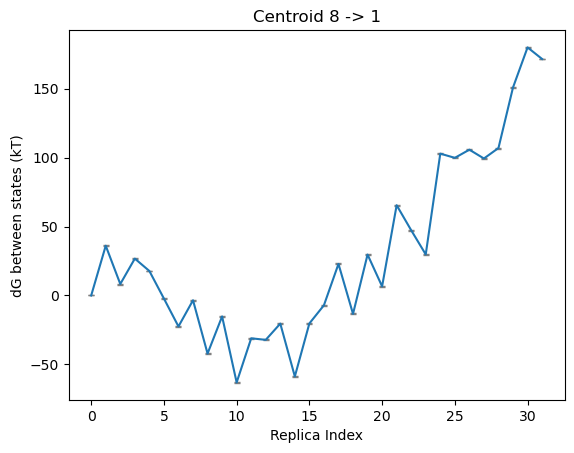

t0 944
944 <analysis.FultonMarketAnalysis.FultonMarketAnalysis object at 0x1555126a3380>


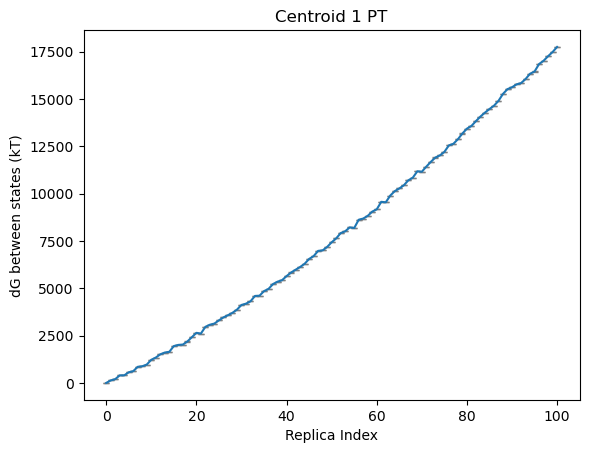

t0 519
519 <analysis.FultonMarketAnalysis.FultonMarketAnalysis object at 0x1555504741d0>


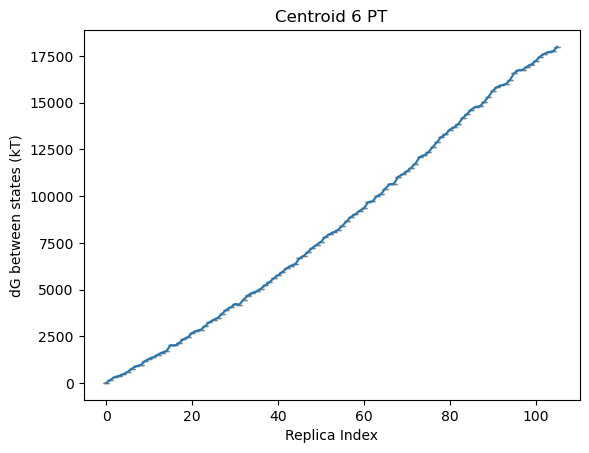

t0 1005
1005 <analysis.FultonMarketAnalysis.FultonMarketAnalysis object at 0x1555118d2ab0>


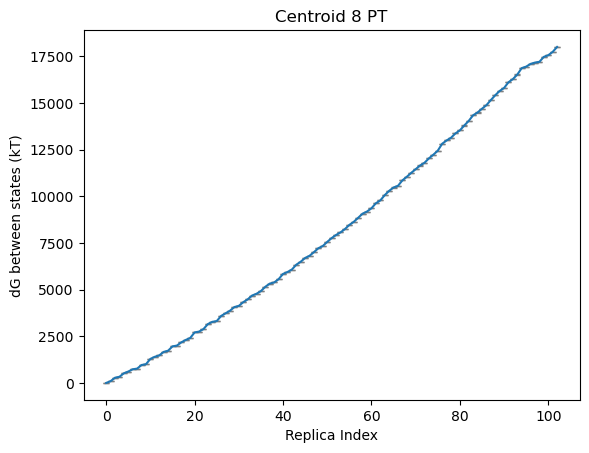

In [5]:
labels = ['Centroid 1 -> 6', 'Centroid 6 -> 8', 'Centroid 8 -> 1', 'Centroid 1 PT', 'Centroid 6 PT', 'Centroid 8 PT']

for i, analyzer in enumerate(analyzers):
    if i > 0:
        t0, dG = free_energy_end(analyzer)
        ys = dG['Delta_f'][0, :]
        y_stds = dG['dDelta_f'][0, :]
        xs = np.arange(ys.shape[0])
        print(t0, analyzer)
        plt.clf()
        _ = plt.errorbar(xs, ys, yerr=y_stds, ecolor='gray', capsize=2.5)
        plt.title(labels[i])
        plt.ylabel('dG between states (kT)')
        plt.xlabel('Replica Index')
        plt.show()

Centroid 1 -> 6
11/01/2024 13:46:30 // Equilibration detected at 133.6 ns


<Figure size 640x480 with 0 Axes>

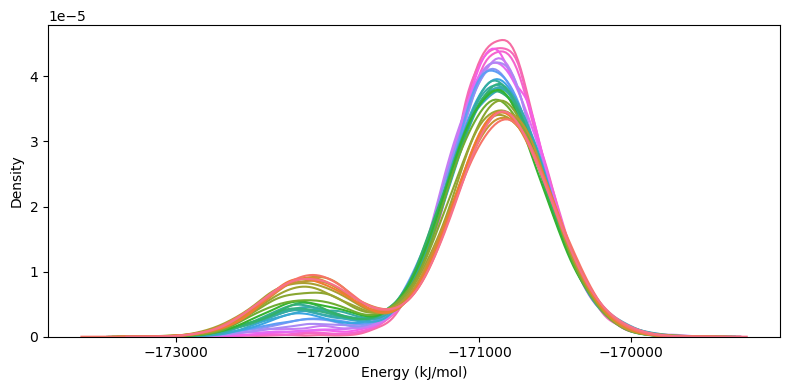

Centroid 6 -> 8
11/01/2024 13:46:35 // Equilibration detected at 564.8 ns


<Figure size 640x480 with 0 Axes>

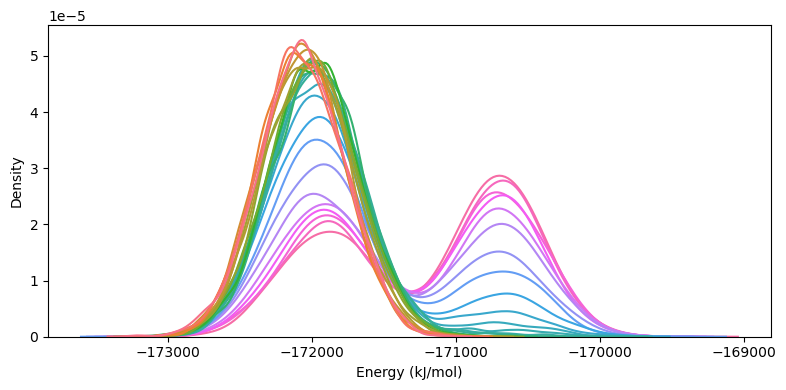

Centroid 8 -> 1
11/01/2024 13:46:36 // Equilibration detected at 44.7 ns


<Figure size 640x480 with 0 Axes>

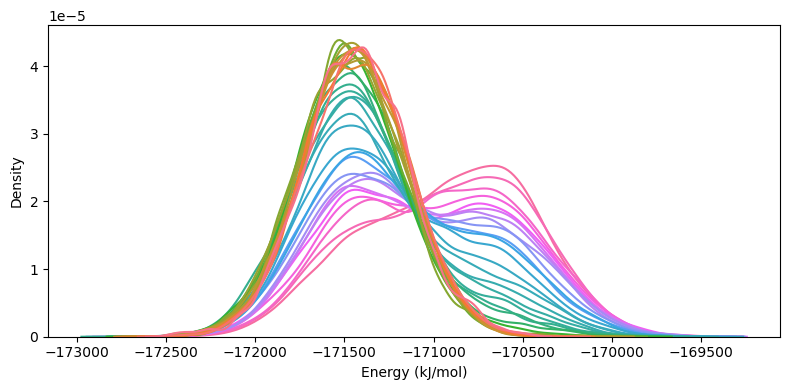

Centroid 1 PT
11/01/2024 13:46:37 // Equilibration detected at 94.4 ns


<Figure size 640x480 with 0 Axes>

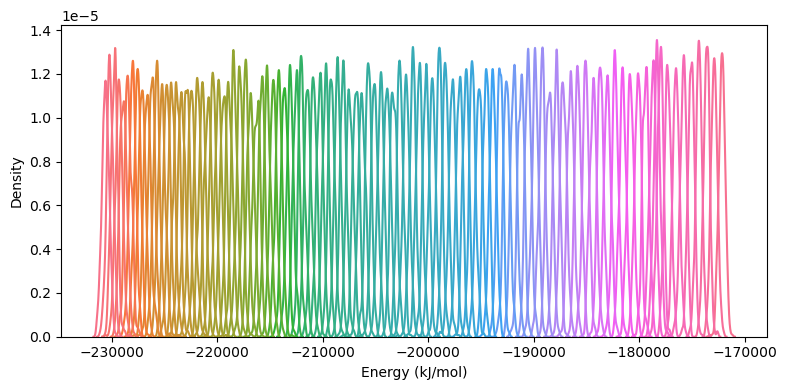

Centroid 6 PT
11/01/2024 13:46:38 // Equilibration detected at 51.9 ns


<Figure size 640x480 with 0 Axes>

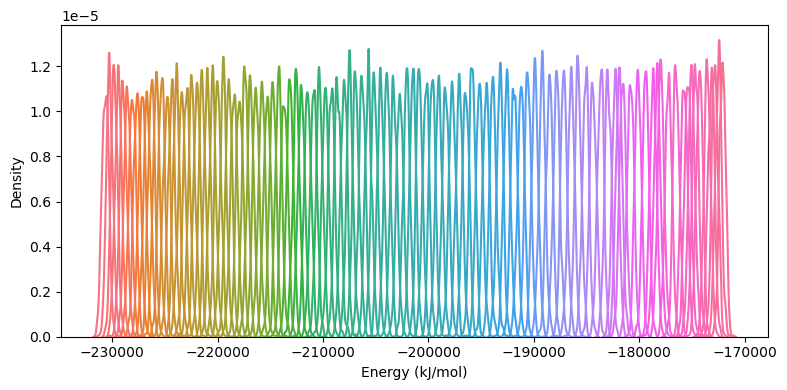

Centroid 8 PT
11/01/2024 13:46:39 // Equilibration detected at 100.5 ns


<Figure size 640x480 with 0 Axes>

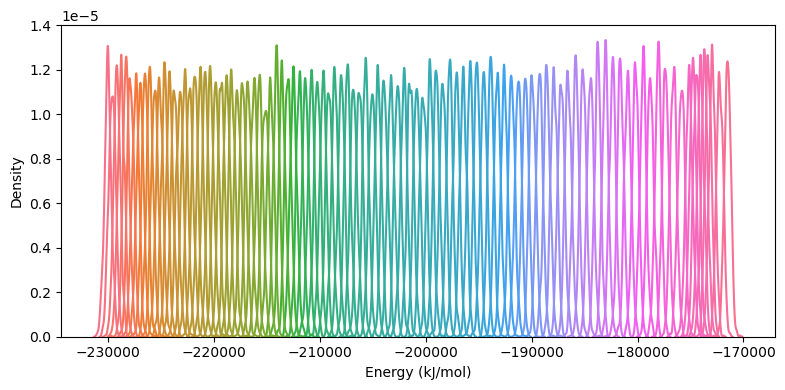

In [6]:
for i, analyzer in enumerate(analyzers):
    plt.clf()
    print(labels[i])
    analyzer.equilibration_method = 'energy'
    fig, ax = analyzer.plot_energy_distributions(post_equil=True)
    plt.show()        

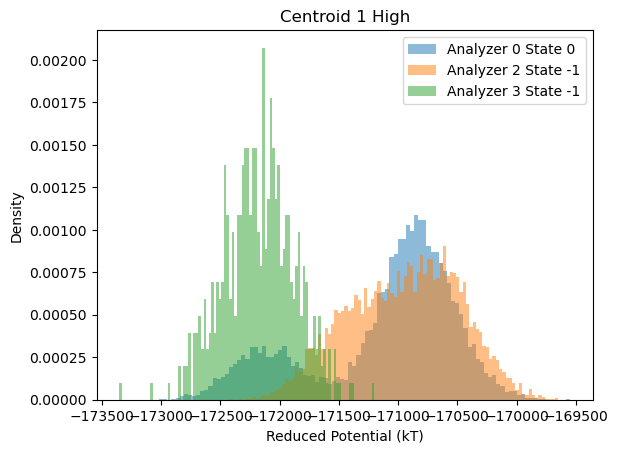

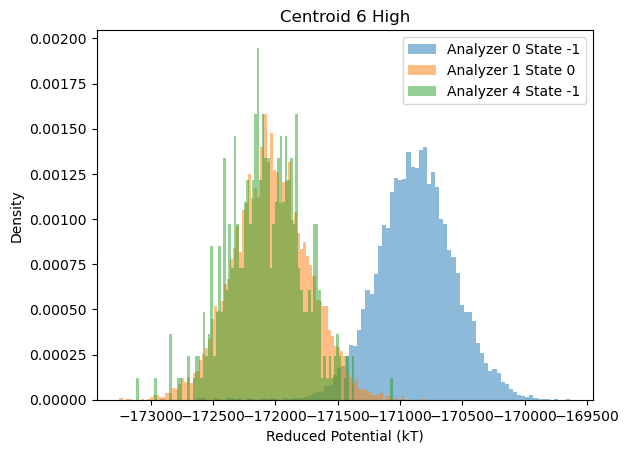

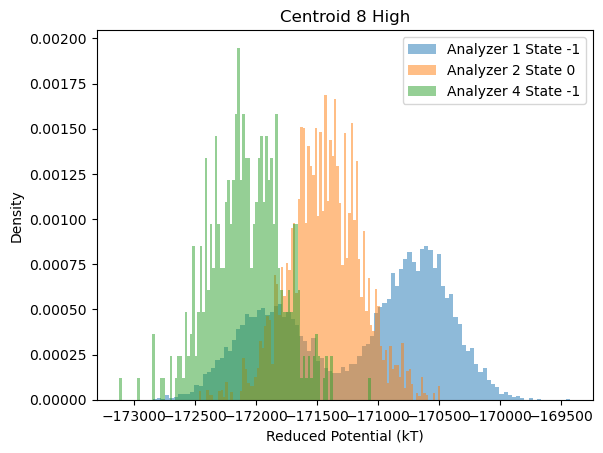

In [7]:
#Sanity Check, plot the reduced potential distributions of three endstates from three legs which should all be the same state
# (Analyzer, State)
centroid_1_high = ((0, 0), (2, -1), (3,-1))
centroid_6_high = ((0, -1), (1, 0), (4, -1))
centroid_8_high = ((1, -1), (2, 0), (4, -1))

labels = ["Centroid 1 High", "Centroid 6 High", "Centroid 8 High"]
for i, centroid_set in enumerate([centroid_1_high, centroid_6_high, centroid_8_high]):
    
    plt.clf()
    plt.title(labels[i])
    for index_pair in centroid_set:
        label = f"Analyzer {index_pair[0]} State {index_pair[-1]}"
        all_eners = analyzers[index_pair[0]].energies
        data = all_eners[analyzer.t0:, index_pair[-1], index_pair[-1]]
        _ = plt.hist(data, density=True, bins=100, alpha=0.5, label=label)
    plt.legend()
    plt.xlabel('Reduced Potential (kT)')
    plt.ylabel('Density')
    plt.show()

[1000 1100 1200 1300 1400 1500]
1000


Failed to reach a solution to within tolerance with hybr: trying next method


1100


Failed to reach a solution to within tolerance with hybr: trying next method


1200


Failed to reach a solution to within tolerance with hybr: trying next method


1300
1400


Failed to reach a solution to within tolerance with hybr: trying next method


1500


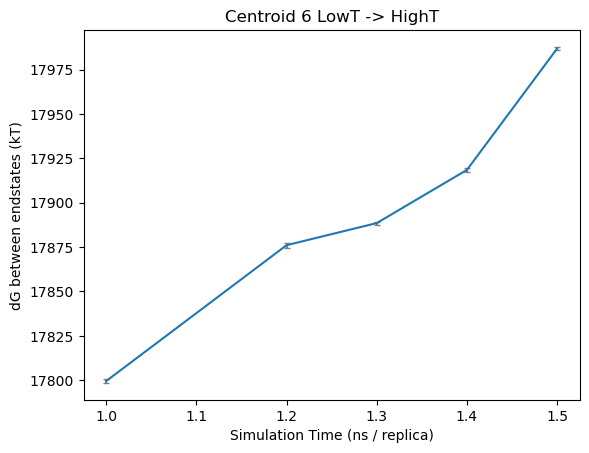

[1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000]
1000


Failed to reach a solution to within tolerance with hybr: trying next method


1100


Failed to reach a solution to within tolerance with hybr: trying next method


1200


Failed to reach a solution to within tolerance with hybr: trying next method


1300
1400


Failed to reach a solution to within tolerance with hybr: trying next method


1500


Failed to reach a solution to within tolerance with hybr: trying next method


1600


Failed to reach a solution to within tolerance with hybr: trying next method


1700
1800
1900
2000


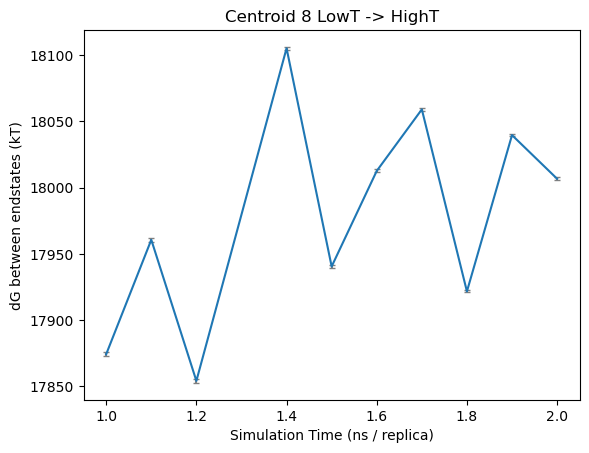

In [9]:
labels = ['Centroid 1 -> 6', 'Centroid 6 -> 8', 'Centroid 8 -> 1',
          'Centroid 1 LowT -> HighT', 'Centroid 6 LowT -> HighT', 'Centroid 8 LowT -> HighT']

xss = []
yss = []
y_stdss = []

for i, analysis in enumerate(analyzers):
    if i > 3:
        xs, ys, y_stds = free_energy_convergence(analysis, size_domain=100, start=1000)
        xss.append(xs)
        yss.append(ys)
        y_stdss.append(y_stds)
        plt.clf()
        _ = plt.errorbar(xs/1000, ys, yerr=y_stds, ecolor='gray', capsize=2.5)
        plt.title(labels[i])
        plt.ylabel('dG between endstates (kT)')
        plt.xlabel('Simulation Time (ns / replica)')
        plt.show()

In [ ]:
# t0, dG = free_energy_end(analyzers[0])

In [ ]:
# dG['Delta_f'][0, :]

In [ ]:
# #Sum around the cycle
# print("Final Free Energy Differences")
# print(f"Centroid 1 -> 6:", yss[0][-1], '+/-', y_stdss[0][-1])
# print(f"Centroid 8 -> 1:", yss[1][-1], '+/-', y_stdss[1][-1])
# print(f"Centroid 8 -> 6:", yss[2][-1], '+/-', y_stdss[2][-1])
# print(f"Centroid 1 Low -> High:", yss[3][-1], '+/-', y_stdss[3][-1])
# print(f"Centroid 6 Low -> High:", yss[4][-1], '+/-', y_stdss[4][-1])
# print(f"Centroid 8 Low -> High:", yss[5][-1], '+/-', y_stdss[5][-1])

In [ ]:
# #Sum of 1->6, 6->8, 8->1
# vals = np.array([yss[0][-1], # 1->6
#                  yss[1][-1], # 8->1
#                  -1*yss[2][-1]]) # -1 * 8->6
# errs = np.array([y_stdss[0][-1],
#                  y_stdss[1][-1],
#                  y_stdss[2][-1]])
# sum_of_cycle = np.sum(vals)
# error_of_cycle = np.sqrt(np.sum(errs**2))
# print("Free Energy Around the Cycle")
# print("Centroid 1 -> 6 -> 8 -> 1", sum_of_cycle, '+/-', error_of_cycle)

In [ ]:
# #Sum Low1 -> Low6
# vals = np.array([yss[3][-1],
#                  yss[0][-1],
#                  -1*yss[4][-1]])
# errs = np.array([y_stdss[3][-1],
#                  y_stdss[0][-1],
#                  y_stdss[4][-1]])
# sum_of_cycle = np.sum(vals)
# error_of_cycle = np.sqrt(np.sum(errs**2))
# print("Free Energy Low1 to Low6")
# print(sum_of_cycle, '+/-', error_of_cycle)

In [ ]:
# #Sum Low8 -> Low6
# vals = np.array([yss[5][-1],
#                  yss[2][-1],
#                  -1*yss[4][-1]])
# errs = np.array([y_stdss[5][-1],
#                  y_stdss[2][-1],
#                  y_stdss[4][-1]])
# sum_of_cycle = np.sum(vals)
# error_of_cycle = np.sqrt(np.sum(errs**2))
# print("Free Energy Low8 to Low6")
# print(sum_of_cycle, '+/-', error_of_cycle)

In [ ]:
# #Sum Low8 -> Low1
# vals = np.array([yss[5][-1],
#                  yss[1][-1],
#                  -1*yss[3][-1]])
# errs = np.array([y_stdss[5][-1],
#                  y_stdss[1][-1],
#                  y_stdss[3][-1]])
# sum_of_cycle = np.sum(vals)
# error_of_cycle = np.sqrt(np.sum(errs**2))
# print("Free Energy Low8 to Low1")
# print(sum_of_cycle, '+/-', error_of_cycle)

In [ ]:
# pairs = (['/expanse/lustre/projects/iit122/dcooper/JustDoIt/umbrella_sampling/test_equilibration/centroid_1_6/', '/expanse/lustre/projects/iit122/dcooper/JustDoIt/umbrella_sampling/test_equilibration/centroid_1.pdb'],
#          ['/expanse/lustre/projects/iit122/dcooper/JustDoIt/umbrella_sampling/test_equilibration/centroid_8_1/', '/expanse/lustre/projects/iit122/dcooper/JustDoIt/umbrella_sampling/test_equilibration/centroid_8.pdb'],
#          ['/expanse/lustre/projects/iit122/dcooper/JustDoIt/umbrella_sampling/test_equilibration/centroid_8_6/', '/expanse/lustre/projects/iit122/dcooper/JustDoIt/umbrella_sampling/test_equilibration/centroid_8.pdb'],
#          ['/expanse/lustre/projects/iit122/dcooper/JustDoIt/umbrella_sampling/test_equilibration/centroid_1_PTwR/centroid_1_1/', '/expanse/lustre/projects/iit122/dcooper/JustDoIt/umbrella_sampling/test_equilibration/centroid_1.pdb'],
#          ['/expanse/lustre/projects/iit122/dcooper/JustDoIt/umbrella_sampling/test_equilibration/centroid_6_PTwR/centroid_6_1/', '/expanse/lustre/projects/iit122/dcooper/JustDoIt/umbrella_sampling/test_equilibration/centroid_6.pdb'],
#          ['/expanse/lustre/projects/iit122/dcooper/JustDoIt/umbrella_sampling/test_equilibration/centroid_8_PTwR/centroid_8_1/', '/expanse/lustre/projects/iit122/dcooper/JustDoIt/umbrella_sampling/test_equilibration/centroid_8.pdb'])

In [ ]:
# data = dGs['Delta_f'][0, :]

In [ ]:
# plt.clf()
# _ = plt.plot(np.arange(data.shape[0]), data)
# plt.ylabel('dG (kT)')
# plt.xlabel('Replica')
# plt.show()

In [ ]:
#Check the convergence by getting the deltaG between endstates as a function of simulation time
#average_energies = analysis.get_average_energy(plot=True)[0]

In [29]:
pdb_pairs = [['/expanse/lustre/projects/iit122/dcooper/JustDoIt/centroids/centroid_1.pdb', '/expanse/lustre/projects/iit122/dcooper/JustDoIt/centroids/centroid_6.pdb'],
             ['/expanse/lustre/projects/iit122/dcooper/JustDoIt/centroids/centroid_6.pdb', '/expanse/lustre/projects/iit122/dcooper/JustDoIt/centroids/centroid_8.pdb'],
             ['/expanse/lustre/projects/iit122/dcooper/JustDoIt/centroids/centroid_8.pdb', '/expanse/lustre/projects/iit122/dcooper/JustDoIt/centroids/centroid_1.pdb']]

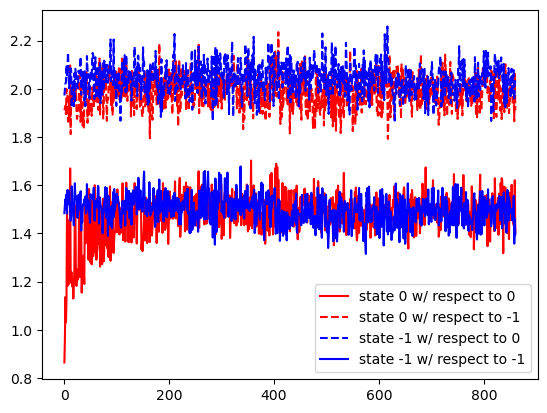

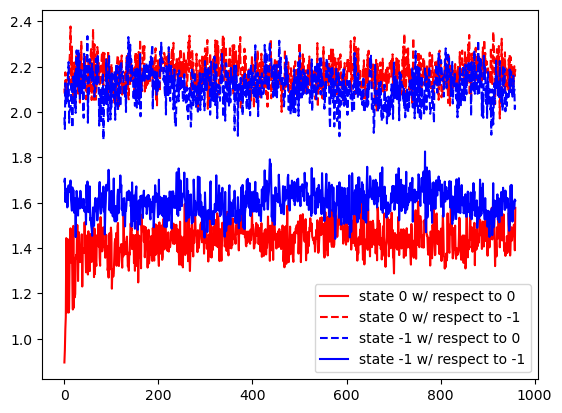

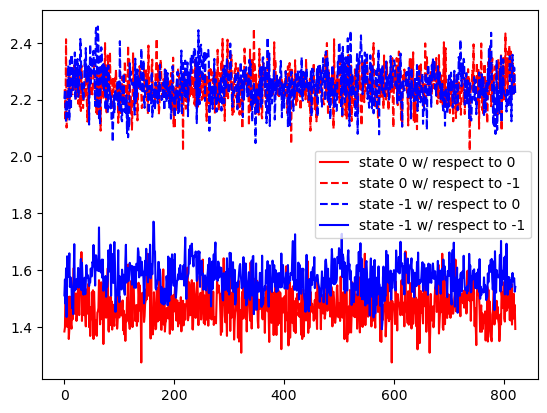

In [30]:
for i, analysis in enumerate(analyzers[:3]):
    pdb1, pdb2 = pdb_pairs[i]
    traj1 = analysis.state_trajectory(0, stride=10)
    traj2 = analysis.state_trajectory(-1, stride=10)
    traj1p = md.load_pdb(pdb1)
    traj2p = md.load_pdb(pdb2)
    intracellular_inds = [84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349]
    intracellular_inds = [ind - 67 for ind in intracellular_inds]
    prot_sel = traj1.topology.select('protein and name CA')
    sel = traj1.topology.select(f'protein and resid {" ".join([str(i) for i in intracellular_inds])}')

    RMSD1_1p = md.rmsd(traj1, traj1p, frame=0, atom_indices=sel, ref_atom_indices=sel)*10
    RMSD1_2p = md.rmsd(traj1, traj2p, frame=0, atom_indices=sel, ref_atom_indices=sel)*10
    RMSD2_1p = md.rmsd(traj2, traj1p, frame=0, atom_indices=sel, ref_atom_indices=sel)*10
    RMSD2_2p = md.rmsd(traj2, traj2p, frame=0, atom_indices=sel, ref_atom_indices=sel)*10

    plt.clf()
    plt.plot(range(traj1.n_frames), RMSD1_1p, 'r', label='state 0 w/ respect to 0')
    plt.plot(range(traj1.n_frames), RMSD1_2p, 'r', label='state 0 w/ respect to -1', linestyle='dashed')
    plt.plot(range(traj1.n_frames), RMSD2_1p, 'b', label='state -1 w/ respect to 0', linestyle='dashed')
    plt.plot(range(traj1.n_frames), RMSD2_2p, 'b', label='state -1 w/ respect to -1')
    
    plt.legend()
    plt.show()

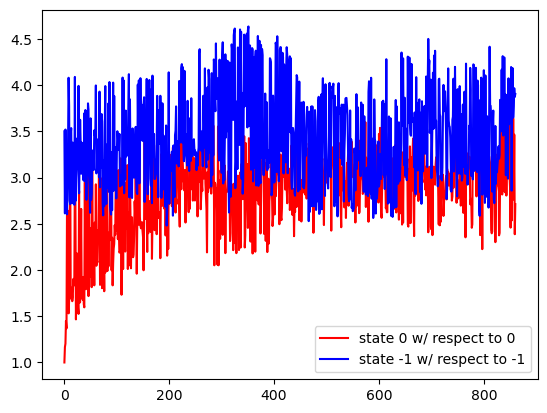

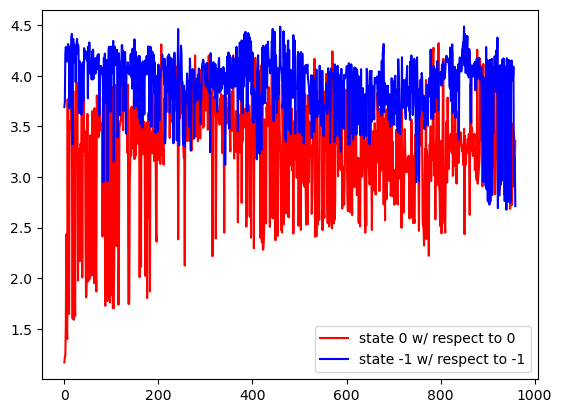

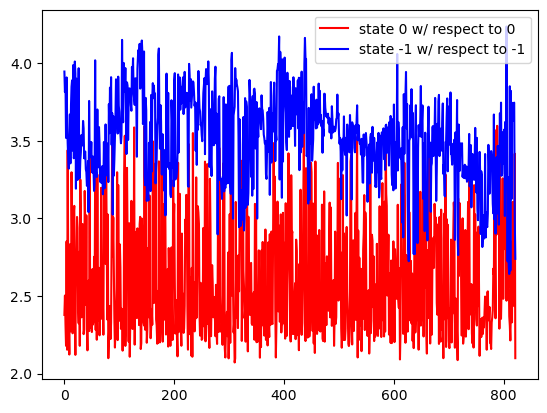

In [31]:
for i, analysis in enumerate(analyzers[:3]):
    pdb1, pdb2 = pdb_pairs[i]
    traj1 = analysis.state_trajectory(0, stride=10)
    traj2 = analysis.state_trajectory(-1, stride=10)
    traj1p = md.load_pdb(pdb1)
    traj2p = md.load_pdb(pdb2)
    intracellular_inds = [84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349]
    intracellular_inds = [ind - 67 for ind in intracellular_inds]
    bp_inds = [i for i in range(67,353) if i not in intracellular_inds]
    prot_sel = traj1.topology.select('protein and name CA')
    sel = traj1.topology.select(f'protein and resid {" ".join([str(i) for i in bp_inds])}')

    RMSD1_1p = md.rmsd(traj1, traj1p, frame=0, atom_indices=sel, ref_atom_indices=sel)*10
    RMSD1_2p = md.rmsd(traj1, traj2p, frame=0, atom_indices=sel, ref_atom_indices=sel)*10
    RMSD2_1p = md.rmsd(traj2, traj1p, frame=0, atom_indices=sel, ref_atom_indices=sel)*10
    RMSD2_2p = md.rmsd(traj2, traj2p, frame=0, atom_indices=sel, ref_atom_indices=sel)*10

    plt.clf()
    plt.plot(range(traj1.n_frames), RMSD1_1p, 'r', label='state 0 w/ respect to 0')
    # plt.plot(range(traj1.n_frames), RMSD1_2p, 'r', label='state 0 w/ respect to -1', linestyle='dashed', alpha=0.25)
    # plt.plot(range(traj1.n_frames), RMSD2_1p, 'b', label='state -1 w/ respect to 0', linestyle='dashed', alpha=0.25)
    plt.plot(range(traj1.n_frames), RMSD2_2p, 'b', label='state -1 w/ respect to -1')
    
    plt.legend()
    plt.show()

In [ ]:
traj1 = analysis.state_trajectory(0, stride=10)
traj2 = analysis.state_trajectory(-1, stride=10)
traj1p = md.load_pdb(pdb1)
traj2p = md.load_pdb(pdb2)
intracellular_inds = [84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349]
intracellular_inds = [ind - 67 for ind in intracellular_inds]
prot_sel = traj1.topology.select('protein and name CA')
sel = traj1.topology.select(f'resid {" ".join([str(i) for i in intracellular_inds])}')

In [ ]:
RMSD1_1p = md.rmsd(traj1, traj1p, frame=0, atom_indices=sel, ref_atom_indices=sel)*10
RMSD1_2p = md.rmsd(traj1, traj2p, frame=0, atom_indices=sel, ref_atom_indices=sel)*10
RMSD2_1p = md.rmsd(traj2, traj1p, frame=0, atom_indices=sel, ref_atom_indices=sel)*10
RMSD2_2p = md.rmsd(traj2, traj2p, frame=0, atom_indices=sel, ref_atom_indices=sel)*10

In [ ]:
plt.plot(range(traj1.n_frames), RMSD1_1p, 'r', label='state 0 w/ respect to 0')
plt.plot(range(traj1.n_frames), RMSD1_2p, 'r', label='state 0 w/ respect to -1', linestyle='dashed')
plt.plot(range(traj1.n_frames), RMSD2_1p, 'b', label='state -1 w/ respect to 0', linestyle='dashed')
plt.plot(range(traj1.n_frames), RMSD2_2p, 'b', label='state -1 w/ respect to -1')

plt.legend()
plt.show()

In [ ]:
RMSF1 = md.rmsf(traj1, traj1, atom_indices=prot_sel, ref_atom_indices=prot_sel)*10
RMSF2 = md.rmsf(traj2, traj2, atom_indices=prot_sel, ref_atom_indices=prot_sel)*10

colors = []
for resid in range(len(RMSF1)):
    if resid in intracellular_inds:
        colors.append('red')
    else:
        colors.append('blue')

plt.bar(range(len(RMSF1)), RMSF1, color=colors)
plt.show()
plt.bar(range(len(RMSF1)), RMSF2, color=colors)
plt.show()

In [ ]:
# Restraints
selection_string = 'protein and ('
intracellular_inds = [84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349]
intracellular_inds = [ind - 67 for ind in intracellular_inds]
print(intracellular_inds)
for ind in intracellular_inds:
    selection_string += f'(resid {ind}) or '
selection_string = selection_string[:-4] + ')'

sele = traj1.topology.select(selection_string)

In [ ]:
from openmm.app import PDBFile
from openmm import *

pdbfile = PDBFile(pdb1)
top = pdbfile.topology
with open(sys_fn, 'r') as f:
    system = XmlSerializer.deserialize(f.read())

